In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/segmentation/'
model_path = model_base_path + '54-fpn_inceptionv3_320x480.h5'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_path = 'train_images/'

### Load data

In [7]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [0]:
BACKBONE = 'inceptionv3'
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
segmentation_model = load_model(model_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Segmentation threshold and mask size tunning

In [11]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
threshold_grid = np.arange(.3, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=1000)

Fish treshold=0.60 mask size=20000 Dice=0.618
Flower treshold=0.35 mask size=17500 Dice=0.768
Gravel treshold=0.30 mask size=17500 Dice=0.628
Sugar treshold=0.65 mask size=10000 Dice=0.606


# Model evaluation

In [12]:
train_metrics = get_metrics(segmentation_model, train, X_train, train_images_path, (HEIGHT, WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Train', batch_size=1000)
display(train_metrics)

validation_metrics = get_metrics(segmentation_model, train, X_val, train_images_path, (HEIGHT, WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Validation', batch_size=1000)
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.506168,0.629446
Flower,0.743497,0.778843
Gravel,0.566110,0.624626
Sugar,0.531869,0.600809
Train,0.586911,0.658431


,Dice,Dice Post
Class,,
Fish,0.493189,0.617789
Flower,0.719599,0.767893
Gravel,0.565698,0.628348
Sugar,0.537021,0.606182
Validation,0.578877,0.655053


## Inspecting some of the validation set predictions

### Without post-process

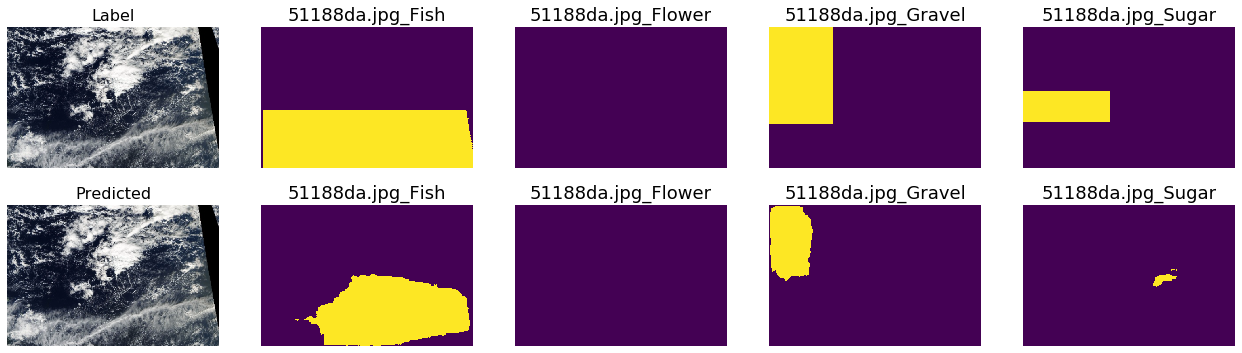

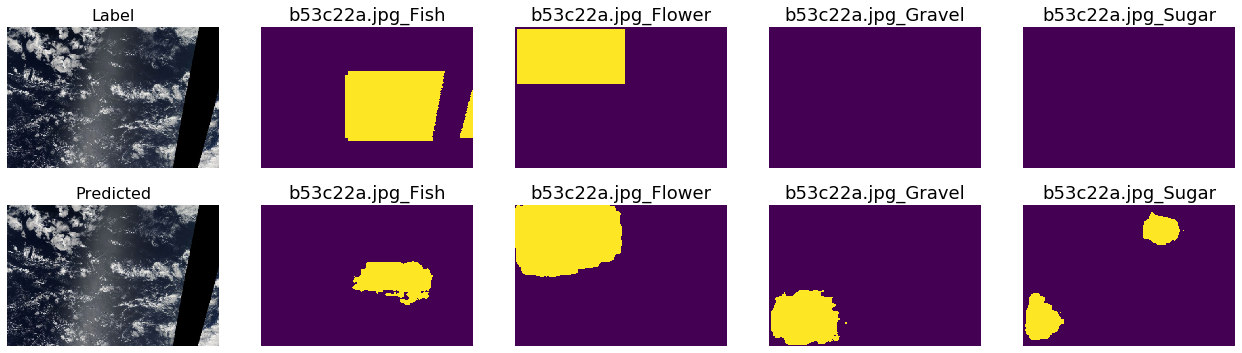

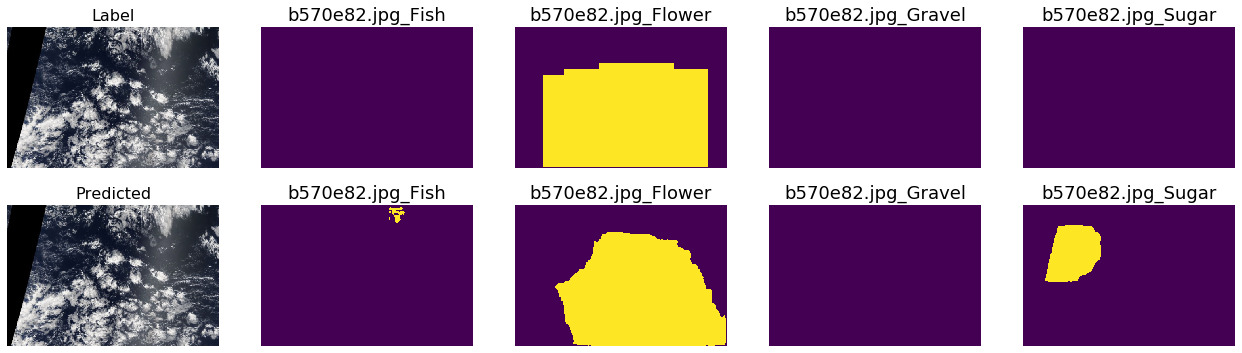

In [13]:
#@title
images_to_inspect = np.random.choice(X_val['image'].unique(), 3, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_class = X_val[X_val['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks[..., class_index]
        pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
        pred_masks[...,class_index] = pred_mask

    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[..., class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    
    inspect_set_temp.append(image_df)

inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

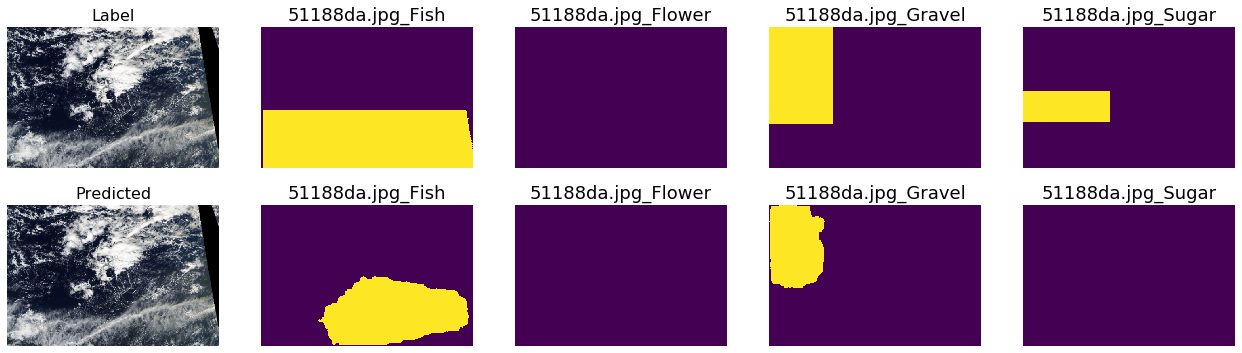

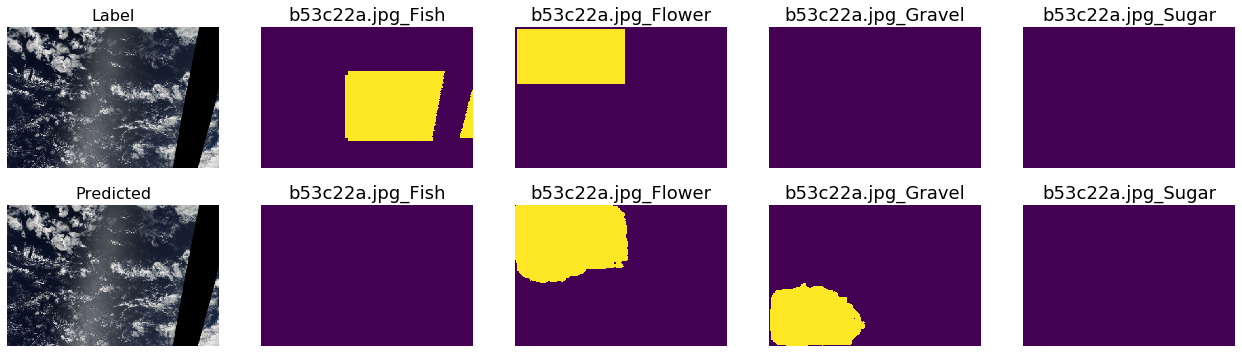

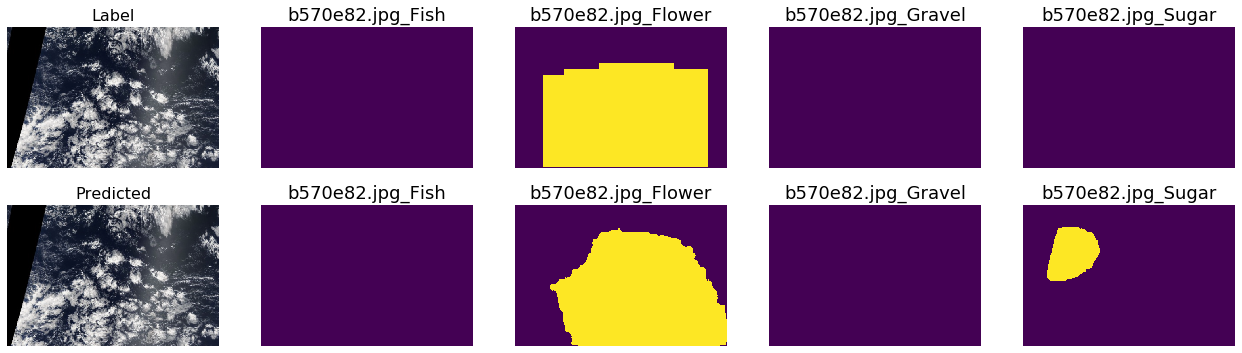

In [14]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

# Using TTA Wrapper

In [15]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
segmentation_model_tta.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, None, None, 3)        0         
_________________________________________________________________
repeat_1 (Repeat)            (4, None, None, 3)        0         
_________________________________________________________________
tta_1 (TTA)                  (4, None, None, 3)        0         
_________________________________________________________________
model_1 (Model)              multiple                  25032740  
_________________________________________________________________
tta_2 (TTA)                  (4, None, None, 4)        0         
_________________________________________________________________
merge_1 (Merge)              (1, None, None, 4)        0         
Total params: 25,032,740
Trainable params: 24,996,004
Non-trainable params: 36,736
_________________________________________

### Without post-process and TTA

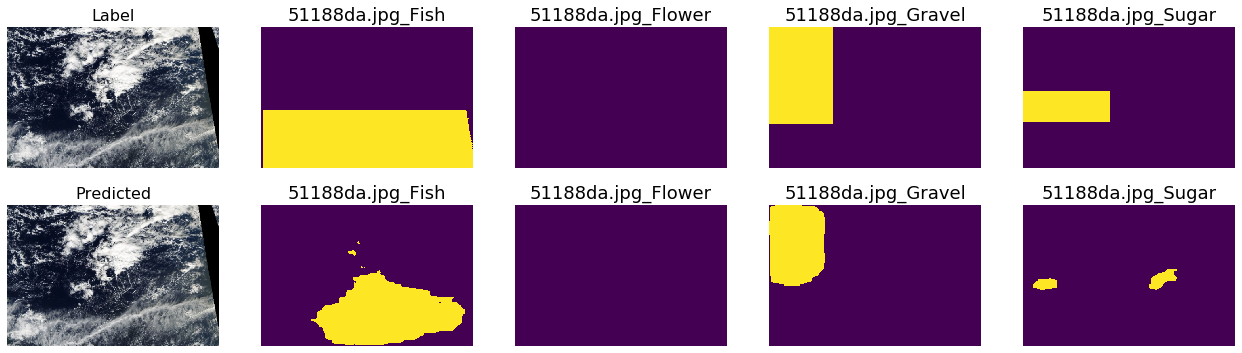

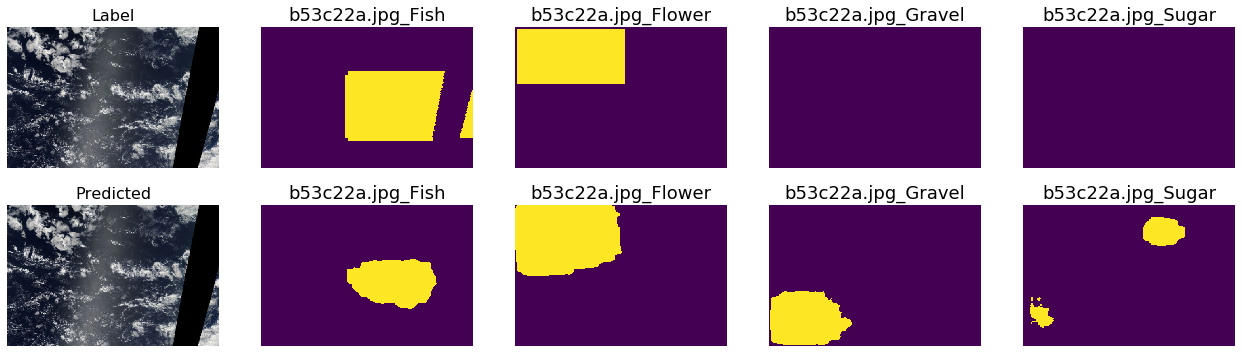

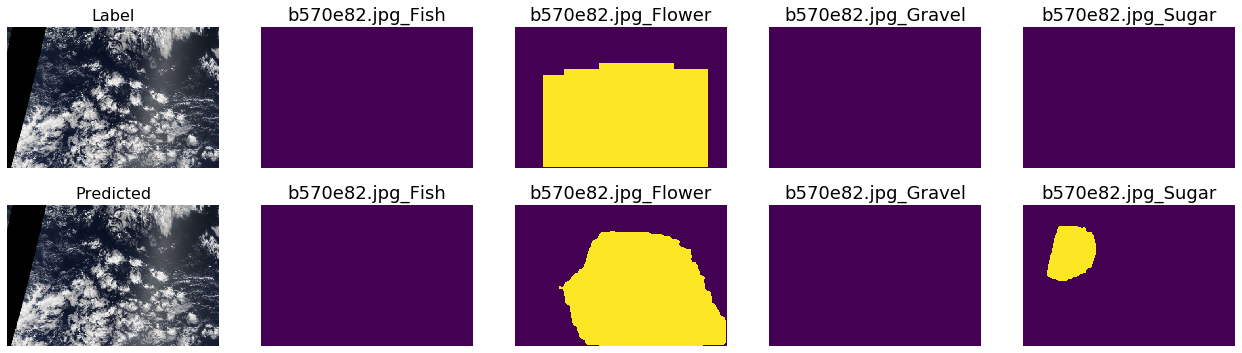

In [16]:
#@title
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model_tta.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    # pred_masks = preds[index, ].round().astype(int)
    pred_masks = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks[..., class_index]
        pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
        pred_masks[...,class_index] = pred_mask

    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post

    inspect_set_temp.append(image_df)


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process and TTA

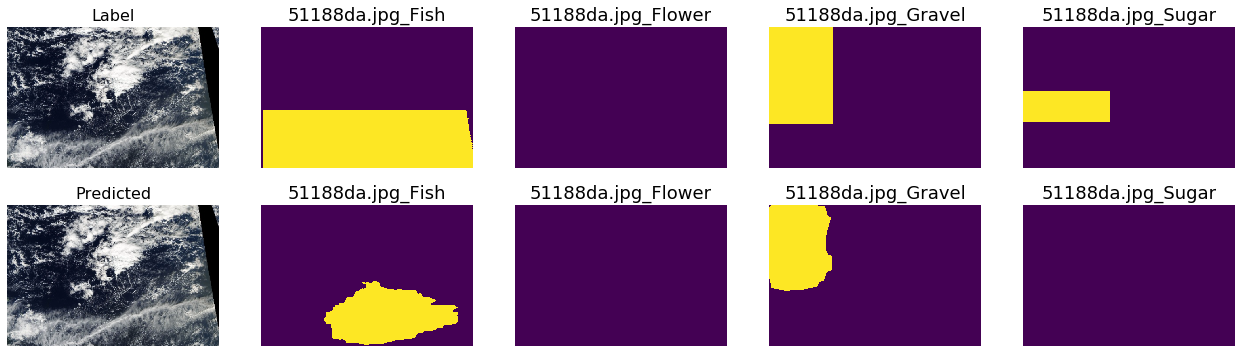

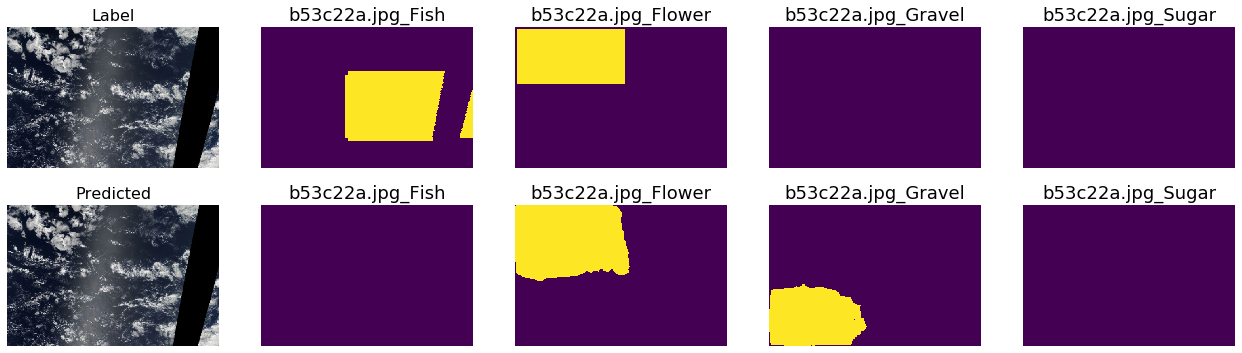

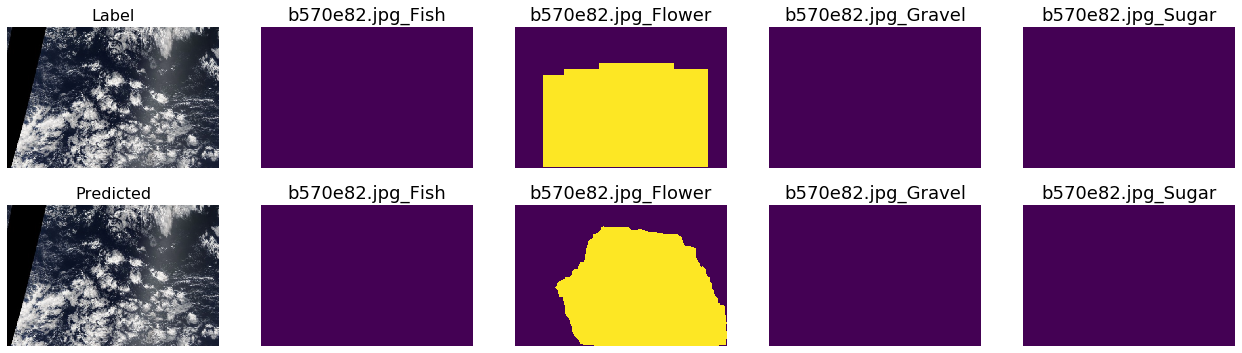

In [17]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')